# Latent matrices

Select two of your generated images together with their latent noise matrix; 
interpolate linearly between the two latent matrices to generate 8 additional latent matrices; use these 8 matrices to generate images from your model; present the 10 generated images (8 newly generated and 2 generated  previously) and discuss the importance of the results

In [ ]:
# !git clone https://github.com/milmor/LadaGAN-pytorch.git

Cloning into 'LadaGAN-pytorch'...


In [4]:
# !python -m pip install einops

In [34]:
import sys
sys.path.append('LadaGAN')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
from model import Generator
from utils import Config
from config import config
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

In [ ]:
model_dir = '../res/test_model_final/test_model'
best_model_path = model_dir + "/best_ckpt.pt"

In [ ]:
conf = Config(config, model_dir)
ckpt = torch.load(best_model_path, map_location='cpu', weights_only=False)  # or 'cuda' if using GPU
generator = Generator(
    conf.img_size, conf.g_dim, conf.noise_dim, conf.g_heads, conf.g_mlp
)
generator.load_state_dict(ckpt['generator'])  # or adjust key if different
generator.eval()

Generator(
  (init): Sequential(
    (0): Linear(in_features=128, out_features=65536, bias=False)
  )
  (block_64): SMLadaformer(
    (ln_1): SelfModulatedLayerNorm(
      (param_free_norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=False)
      (h): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): ReLU()
      )
      (mlp_gamma): Linear(in_features=1024, out_features=1024, bias=True)
      (mlp_beta): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (attn): AdditiveAttention(
      (to_qkv): Linear(in_features=1024, out_features=3072, bias=True)
      (q_attn): Linear(in_features=1024, out_features=4, bias=True)
      (to_out): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (ln_2): SelfModulatedLayerNorm(
      (param_free_norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=False)
      (h): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): ReLU()
      )


In [41]:
def gen_image(seed_noise):
    x_fake = generator(seed_noise)
    image = x_fake[0]

    if image.min() < 0 or image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())
    img = to_pil_image(image)
    return img

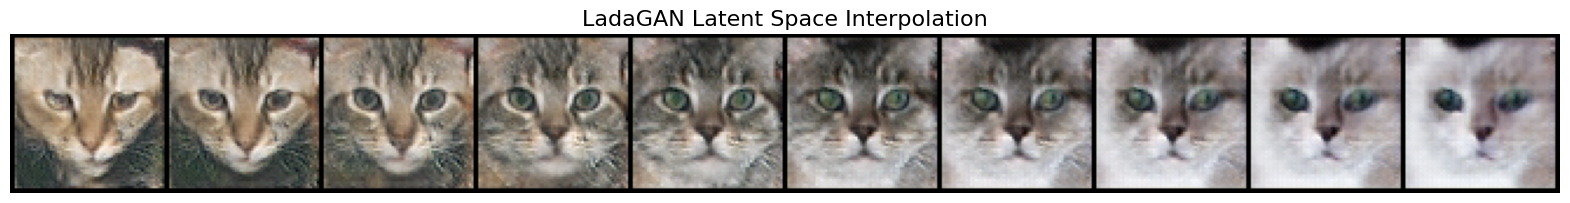

In [72]:
from torchvision.transforms import ToTensor
latent_dim = 128
torch.manual_seed(900)
z0 = torch.normal(0.0, 1.0, size=[1, conf.noise_dim])
z1 = torch.normal(0.0, 1.0, size=[1, conf.noise_dim])

alphas = np.linspace(0, 1, 10)
z_interpolated = [(1 - a) * z0 + a * z1 for a in alphas]
z_batch = torch.cat(z_interpolated, dim=0) 

generated_images = []
for z in z_batch: 
    z = z.view(1, latent_dim)
    generated_images.append(gen_image(z))

tensor_images = [ToTensor()(img) for img in generated_images]
grid = make_grid(tensor_images, nrow=10)
plt.figure(figsize=(20, 4))
plt.imshow(to_pil_image(grid))
plt.axis("off")
plt.title("LadaGAN Latent Space Interpolation", fontsize=16)
plt.savefig("latent_fig.png")
plt.show()

# LOGI z treningu

2025-06-09 21:21:38.093468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
E0000 00:00:1749504098.132842   20087 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749504098.149146   20087 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-09 21:21:38.190241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
New config test_model/config.json saved
img_size: 64
batch_size: 64
noise_dim: 128
g_lr: 0.0002
g_beta1: 0.5
g_beta2: 0.99
g_dim: [1024, 256, 64]
g_heads: [4, 4, 4]
g_mlp: [512, 512, 512]
d_lr: 0.0002
d_beta1: 0.5
d_beta2: 0.99
r1_gamma: 0.01
d_enc_dim: [64, 128, 256]
d_out_dim: [512, 1024]
d_heads: 4
d_mlp: 512
fid_batch_size: 50
gen_batch_size: 50
policy: color,translation
ema_decay: 0.999
n_fid_real: 1000
n_fid_gen: 1000
n_iter: 12000
plot_shape: (8, 8)
Dataset size: 1000 Loader batches: 15
New model initialized

Time for 64000 images is 640.65 sec G loss: 0.9002 D loss: 1.3240
Generating eval batches...
100% 20/20 [00:01<00:00, 13.05it/s]
1000 real images
New files created and saved: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 29.1261 sec
FID: 348.7518078599951
Checkpoint saved at iter 1000
Best checkpoint saved at iter 1000

Time for 128000 images is 647.61 sec G loss: 0.7543 D loss: 1.3658
Generating eval batches...
100% 20/20 [00:01<00:00, 12.65it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 22.7971 sec
FID: 168.91270333447667
Checkpoint saved at iter 2000
Best checkpoint saved at iter 2000

Time for 192000 images is 647.64 sec G loss: 0.7389 D loss: 1.3698
Generating eval batches...
100% 20/20 [00:01<00:00, 12.29it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 23.3006 sec
FID: 79.63164938493478
Checkpoint saved at iter 3000
Best checkpoint saved at iter 3000

Time for 256000 images is 647.87 sec G loss: 0.7352 D loss: 1.3699
Generating eval batches...
100% 20/20 [00:01<00:00, 12.07it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 26.6916 sec
FID: 57.71501580519973
Checkpoint saved at iter 4000
Best checkpoint saved at iter 4000

Time for 320000 images is 647.07 sec G loss: 0.7447 D loss: 1.3629
Generating eval batches...
100% 20/20 [00:01<00:00, 11.49it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 26.5772 sec
FID: 48.406388754746786
Checkpoint saved at iter 5000
Best checkpoint saved at iter 5000

Time for 384000 images is 647.42 sec G loss: 0.7560 D loss: 1.3529
Generating eval batches...
100% 20/20 [00:02<00:00,  9.56it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 26.1772 sec
FID: 44.00947665331668
Checkpoint saved at iter 6000
Best checkpoint saved at iter 6000

Time for 448000 images is 647.57 sec G loss: 0.7764 D loss: 1.3375
Generating eval batches...
100% 20/20 [00:01<00:00, 11.23it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 28.2336 sec
FID: 43.19006901577907
Checkpoint saved at iter 7000
Best checkpoint saved at iter 7000

Time for 512000 images is 647.58 sec G loss: 0.8078 D loss: 1.3131
Generating eval batches...
100% 20/20 [00:01<00:00, 12.36it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 24.3488 sec
FID: 41.35000032399688
Checkpoint saved at iter 8000
Best checkpoint saved at iter 8000

Time for 576000 images is 647.18 sec G loss: 0.8422 D loss: 1.2877
Generating eval batches...
100% 20/20 [00:01<00:00, 12.49it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 28.1760 sec
FID: 40.97731836777726
Checkpoint saved at iter 9000
Best checkpoint saved at iter 9000

Time for 640000 images is 647.38 sec G loss: 0.8776 D loss: 1.2612
Generating eval batches...
100% 20/20 [00:01<00:00, 12.42it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 25.8601 sec
FID: 40.29748042175669
Checkpoint saved at iter 10000
Best checkpoint saved at iter 10000

Time for 704000 images is 647.35 sec G loss: 0.9138 D loss: 1.2358
Generating eval batches...
100% 20/20 [00:01<00:00, 12.01it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 27.0443 sec
FID: 47.30186283915475
Checkpoint saved at iter 11000

Time for 768000 images is 647.38 sec G loss: 0.9489 D loss: 1.2104
Generating eval batches...
100% 20/20 [00:01<00:00, 10.67it/s]
Existing files loaded: ./eval_path/m_1000_pt.npy, ./eval_path/s_1000_pt.npy
1000 gen images
Time for FID is 25.9285 sec
FID: 43.62577255571878
Checkpoint saved at iter 12000